## 1. Import Pakages

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## 2. 하이퍼파라미터 세팅

In [2]:
batch_size = 100
num_epochs = 300
learning_rate = 0.0002
z_size = 50

## 3. Dataset 및 DataLoader 정의

In [3]:
root = '../data/mnist'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = dset.MNIST(root=root, train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(
                 dataset=train_data,
                 batch_size=batch_size,
                 shuffle=True)

## 4. 데이터 시각화

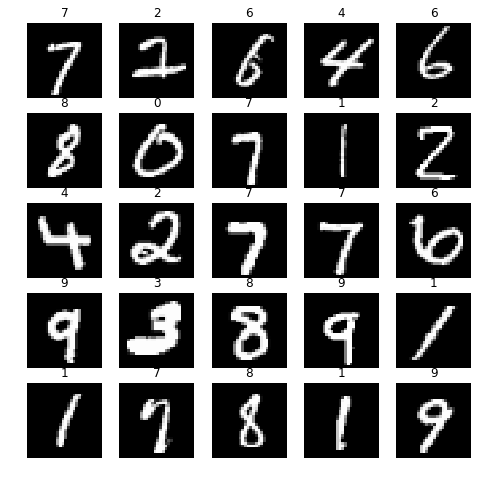

In [4]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0][0,:,:].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    label = train_data[data_idx][1] # item()을 통해 torch Tensor를 숫자로 변환
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

## 5. 네트워크 설계

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(-1, 1, 28, 28)
        return img

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.view(img.shape[0], -1)
        validity = self.model(img)
        return validity

## 6. 모델 생성 및 loss function, optimizer 정의

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
discriminator = Discriminator().to(device)
adversarial_loss = torch.nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

## 7. Training

In [8]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)
        real_imgs = imgs.to(device)
        z = nn.init.normal(torch.Tensor(batch_size,z_size),mean=0,std=0.1).to(device)
        
        # 코드 시작
        gen_imgs = generator(z) # G에 z를 입력으로 주어 이미지 생성
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # G_loss 측정, G가 만들어낸 이미지를 D에게 주었을 때,
                                                                  # D가 그것을 얼마나 real 하다고 하는지를 측정.
        optimizer_G.zero_grad() # g_loss의 기울기 계산 및 파라미터 업데이트
        g_loss.backward()
        optimizer_G.step()

        real_loss = adversarial_loss(discriminator(real_imgs), valid)  # D의 real_loss 측정, D에게 real 이미지를 주었을 때,
                                                                       # D가 그것을 얼마나 real 하다고 하는지를 측정.     
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # D의 fake_loss 측정, D에게 G가 만든 이미지를 주었을 때,
                                                                             # D가 그것을 얼마나 fake 하다고 하는지를 측정.
        d_loss = (real_loss + fake_loss) / 2
        
        optimizer_D.zero_grad() # d_loss의 기울기 계산 및 파라미터 업데이트
        d_loss.backward()
        optimizer_D.step()
        # 코드 종료

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], D_Loss: {:.4f}, G_Loss: {:.4f}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item()))

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  import sys


Epoch [1/300], Step [100/600], D_Loss: 0.1030, G_Loss: 2.0514
Epoch [1/300], Step [200/600], D_Loss: 0.0315, G_Loss: 2.9209
Epoch [1/300], Step [300/600], D_Loss: 0.0181, G_Loss: 3.4518
Epoch [1/300], Step [400/600], D_Loss: 0.1307, G_Loss: 2.4390
Epoch [1/300], Step [500/600], D_Loss: 0.0105, G_Loss: 4.0266
Epoch [1/300], Step [600/600], D_Loss: 0.0163, G_Loss: 3.6097
Epoch [2/300], Step [100/600], D_Loss: 0.0716, G_Loss: 2.6774
Epoch [2/300], Step [200/600], D_Loss: 0.0252, G_Loss: 3.2733
Epoch [2/300], Step [300/600], D_Loss: 0.0126, G_Loss: 4.0037
Epoch [2/300], Step [400/600], D_Loss: 0.0429, G_Loss: 3.8838
Epoch [2/300], Step [500/600], D_Loss: 0.0681, G_Loss: 2.9981
Epoch [2/300], Step [600/600], D_Loss: 0.0326, G_Loss: 3.3743
Epoch [3/300], Step [100/600], D_Loss: 0.1576, G_Loss: 1.8474
Epoch [3/300], Step [200/600], D_Loss: 0.0659, G_Loss: 2.4900
Epoch [3/300], Step [300/600], D_Loss: 0.0737, G_Loss: 3.2981
Epoch [3/300], Step [400/600], D_Loss: 0.0426, G_Loss: 4.8294
Epoch [3

Epoch [22/300], Step [600/600], D_Loss: 0.0091, G_Loss: 8.0630
Epoch [23/300], Step [100/600], D_Loss: 0.0219, G_Loss: 6.5517
Epoch [23/300], Step [200/600], D_Loss: 0.0007, G_Loss: 14.4305
Epoch [23/300], Step [300/600], D_Loss: 0.0073, G_Loss: 6.0303
Epoch [23/300], Step [400/600], D_Loss: 0.0100, G_Loss: 5.4618
Epoch [23/300], Step [500/600], D_Loss: 0.0051, G_Loss: 8.8395
Epoch [23/300], Step [600/600], D_Loss: 0.0560, G_Loss: 6.2938
Epoch [24/300], Step [100/600], D_Loss: 0.2230, G_Loss: 13.0165
Epoch [24/300], Step [200/600], D_Loss: 0.0131, G_Loss: 5.7673
Epoch [24/300], Step [300/600], D_Loss: 0.0480, G_Loss: 5.0074
Epoch [24/300], Step [400/600], D_Loss: 0.0287, G_Loss: 5.5612
Epoch [24/300], Step [500/600], D_Loss: 0.0310, G_Loss: 6.8103
Epoch [24/300], Step [600/600], D_Loss: 0.0083, G_Loss: 10.5854
Epoch [25/300], Step [100/600], D_Loss: 0.0576, G_Loss: 5.7704
Epoch [25/300], Step [200/600], D_Loss: 0.0054, G_Loss: 5.6263
Epoch [25/300], Step [300/600], D_Loss: 0.0221, G_Lo

Epoch [44/300], Step [400/600], D_Loss: 0.0824, G_Loss: 5.0056
Epoch [44/300], Step [500/600], D_Loss: 0.0363, G_Loss: 6.4347
Epoch [44/300], Step [600/600], D_Loss: 0.0822, G_Loss: 4.3780
Epoch [45/300], Step [100/600], D_Loss: 0.0763, G_Loss: 8.5024
Epoch [45/300], Step [200/600], D_Loss: 0.0379, G_Loss: 6.6207
Epoch [45/300], Step [300/600], D_Loss: 0.0782, G_Loss: 5.0714
Epoch [45/300], Step [400/600], D_Loss: 0.0316, G_Loss: 7.5560
Epoch [45/300], Step [500/600], D_Loss: 0.0541, G_Loss: 4.0527
Epoch [45/300], Step [600/600], D_Loss: 0.0941, G_Loss: 3.3143
Epoch [46/300], Step [100/600], D_Loss: 0.1474, G_Loss: 5.1820
Epoch [46/300], Step [200/600], D_Loss: 0.0496, G_Loss: 5.1391
Epoch [46/300], Step [300/600], D_Loss: 0.1051, G_Loss: 6.0114
Epoch [46/300], Step [400/600], D_Loss: 0.1290, G_Loss: 3.3704
Epoch [46/300], Step [500/600], D_Loss: 0.1441, G_Loss: 2.9255
Epoch [46/300], Step [600/600], D_Loss: 0.1717, G_Loss: 5.0946
Epoch [47/300], Step [100/600], D_Loss: 0.0971, G_Loss:

Epoch [66/300], Step [300/600], D_Loss: 0.0953, G_Loss: 4.5730
Epoch [66/300], Step [400/600], D_Loss: 0.1481, G_Loss: 4.7726
Epoch [66/300], Step [500/600], D_Loss: 0.0369, G_Loss: 5.6081
Epoch [66/300], Step [600/600], D_Loss: 0.0864, G_Loss: 4.7136
Epoch [67/300], Step [100/600], D_Loss: 0.1490, G_Loss: 5.4999
Epoch [67/300], Step [200/600], D_Loss: 0.1492, G_Loss: 3.7350
Epoch [67/300], Step [300/600], D_Loss: 0.1655, G_Loss: 3.3777
Epoch [67/300], Step [400/600], D_Loss: 0.1585, G_Loss: 4.9938
Epoch [67/300], Step [500/600], D_Loss: 0.1985, G_Loss: 4.0324
Epoch [67/300], Step [600/600], D_Loss: 0.1807, G_Loss: 2.7154
Epoch [68/300], Step [100/600], D_Loss: 0.1877, G_Loss: 2.4604
Epoch [68/300], Step [200/600], D_Loss: 0.1748, G_Loss: 3.5294
Epoch [68/300], Step [300/600], D_Loss: 0.1607, G_Loss: 4.0857
Epoch [68/300], Step [400/600], D_Loss: 0.1209, G_Loss: 3.3035
Epoch [68/300], Step [500/600], D_Loss: 0.1137, G_Loss: 3.1815
Epoch [68/300], Step [600/600], D_Loss: 0.2109, G_Loss:

KeyboardInterrupt: 

## 8. Test

/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.


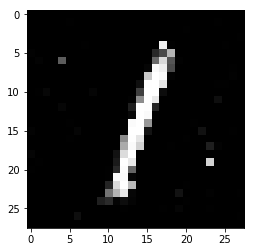

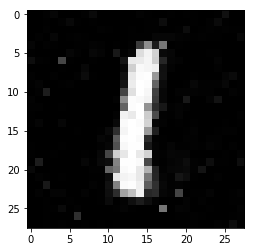

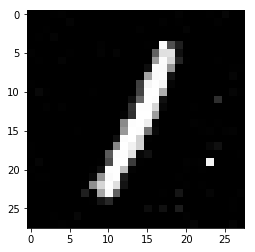

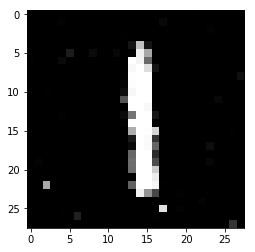

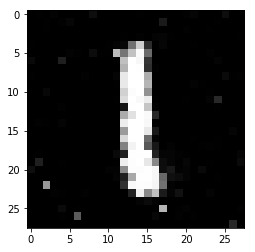

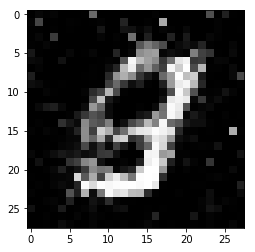

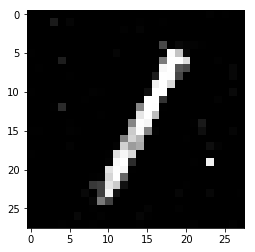

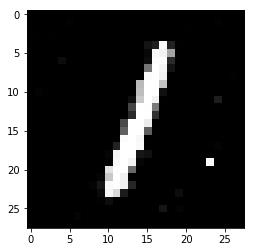

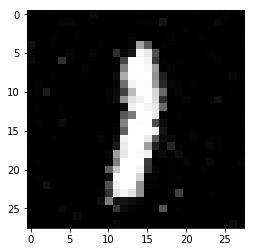

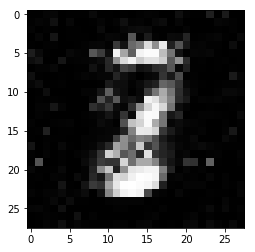

Generator(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [16]:
generator.eval()
with torch.no_grad():
    for i in range(10):
        z = nn.init.normal(torch.Tensor(1,z_size),mean=0,std=0.1)
        gen_imgs = generator(z)
        gen_imgs = gen_imgs.view(1, 28, 28)
        plt.imshow(torch.squeeze(gen_imgs).numpy(), cmap='gray')
        plt.show()
generator.train()